# Merge tracts into neighborhoods from LA county

By: Sandhya Kambhampati 

We want to be able to combine tracts for analysis. In order to do this, we will need a lookup for tracts to neighborhoods. This notebook will create a lookup that can be used for ACS Census data that is on a tract-level.

In [2]:
import warnings, os
import pandas as pd
import numpy as np
import geopandas as gpd
%matplotlib inline

In [3]:
# load in the LA county tracts file 
tracts = gpd.read_file("../data/input/lac-tracts.geojson")

<Axes: >

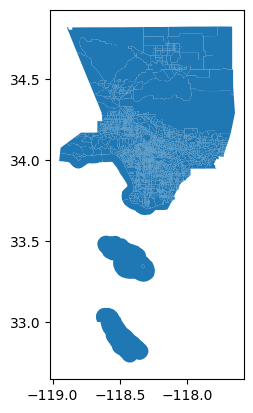

In [4]:
tracts.plot()

In [5]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,06,037,137504,06037137504,1375.04,Census Tract 1375.04,G5020,S,3837562,0,+34.1480383,-118.5720594,"MULTIPOLYGON (((-118.58119 34.14318, -118.5809..."
1,06,037,138000,06037138000,1380,Census Tract 1380,G5020,S,4472196,0,+34.1488008,-118.5910495,"MULTIPOLYGON (((-118.60573 34.14585, -118.6056..."
2,06,037,139200,06037139200,1392,Census Tract 1392,G5020,S,1152028,0,+34.1756961,-118.5246446,"MULTIPOLYGON (((-118.53082 34.18024, -118.5295..."
3,06,037,143200,06037143200,1432,Census Tract 1432,G5020,S,957092,0,+34.1494399,-118.3720618,"MULTIPOLYGON (((-118.37899 34.15409, -118.3788..."
4,06,037,201301,06037201301,2013.01,Census Tract 2013.01,G5020,S,866189,0,+34.0882421,-118.1878388,"MULTIPOLYGON (((-118.19304 34.0859, -118.19294..."


In [6]:
len(tracts)

2498

In [7]:
trimmed_tracts = tracts[[
    'TRACTCE',
    'geometry'
]].rename(columns={"TRACTCE": "tract"})

In [8]:
neighborhood = gpd.read_file("../data/input/la_county.json")

In [9]:
neighborhood.head(1)

,name,slug,geometry
0,Acton,acton,"MULTIPOLYGON (((-118.20262 34.53899, -118.1982..."


<Axes: >

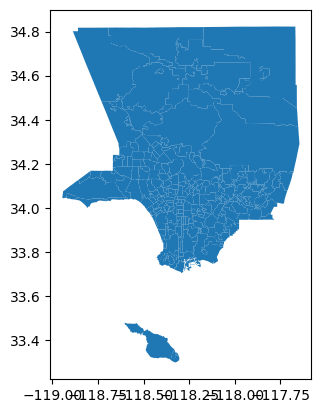

In [10]:
neighborhood.plot()

In [11]:
trimmed_neighborhoods = neighborhood[[
    'name',
    'geometry'
]].rename(columns={"name": "neighborhood"})

In [12]:
trimmed_neighborhoods = trimmed_neighborhoods.to_crs("epsg:2229")

In [13]:
trimmed_tracts = trimmed_tracts.to_crs("epsg:2229")

In [14]:
# merge the two shapefiles together
trimmed_neighborhoods_tracts = gpd.overlay(trimmed_tracts,trimmed_neighborhoods, how='intersection')

/var/folders/3v/0mvr8p6126n1yv0zq8vn8zyr0000gn/T/ipykernel_32342/3924188068.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 4801 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  trimmed_neighborhoods_tracts = gpd.overlay(trimmed_tracts,trimmed_neighborhoods, how='intersection')


<Axes: >

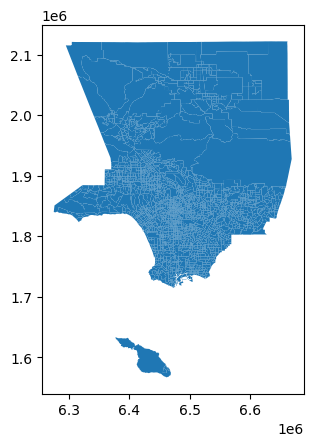

In [15]:
trimmed_neighborhoods_tracts.plot()

In [16]:
len(trimmed_neighborhoods_tracts)

4943

In [17]:
trimmed_neighborhoods_tracts = trimmed_neighborhoods_tracts.to_crs(2229)

In [18]:
# calculate the area covered 
trimmed_neighborhoods_tracts['area'] = trimmed_neighborhoods_tracts['geometry'].area

In [19]:
trimmed_neighborhoods_tracts.sort_values('tract').head()

,tract,neighborhood,geometry,area
2512,101110,Tujunga,"POLYGON ((6470741.805 1916660.388, 6470747.247...",1.229562e+07
3640,101122,Sunland,"MULTIPOLYGON (((6470116.217 1922238.612, 64701...",7.231914e+04
3641,101122,Tujunga,"POLYGON ((6470036.243 1922166.797, 6470052.643...",2.838542e+07
2513,101220,Tujunga,"POLYGON ((6475266.466 1915182.766, 6475267.738...",7.522093e+06
996,101221,Tujunga,"POLYGON ((6471932.721 1915664.436, 6472107.977...",3.812000e+06


In [20]:
trimmed_tracts = trimmed_tracts.to_crs(2229)

In [21]:
# calculate the tracts covered 
trimmed_tracts['total_tract_area'] = trimmed_tracts['geometry'].area

In [22]:
# calculations
calcs = trimmed_neighborhoods_tracts.drop('geometry', axis=1)\
.merge(trimmed_tracts.drop('geometry', axis=1))\
.sort_values('tract')

In [23]:
# tract percent 
calcs['tract_percent'] = calcs['area']/calcs['total_tract_area']

In [24]:
len(calcs)

4943

In [25]:
len(trimmed_neighborhoods_tracts)

4943

In [26]:
calcs.head()

,tract,neighborhood,area,total_tract_area,tract_percent
2512,101110,Tujunga,1.229562e+07,1.229562e+07,1.000000
3640,101122,Sunland,7.231914e+04,2.845774e+07,0.002541
3641,101122,Tujunga,2.838542e+07,2.845774e+07,0.997459
2513,101220,Tujunga,7.522093e+06,7.522093e+06,1.000000
996,101221,Tujunga,3.812000e+06,3.812000e+06,1.000000


In [27]:
calcs.tract.nunique()

2495

In [29]:
# export the csv, first making directories that may not exist yet locally
os.makedirs('../data/output/neighborhood', exist_ok=True)
calcs.to_csv('../data/output/neighborhood/la_tract_to_neighborhood_portions.csv', index=False)